<a href="https://colab.research.google.com/github/paramrajyadav/Duplicate_question/blob/main/duplicateQuestion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [48]:
#pip install tensorflow_text

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [50]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/questions.csv')

In [51]:
df.shape


(404351, 6)

In [52]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [53]:
df = df.sample(30000)

In [54]:
df.duplicated().sum()

0

In [55]:
ques_df = df[['is_duplicate']]
df3 = df['question1'] + ' ' + df['question2']
df3.head()

387399    Is it possible to do a Google Desktop search i...
281419    What is this style of shoe called? I need an o...
223248    Wasn't it greatest Tragedy that Karnas own bro...
338012    Why doesn't indian government ban beef export?...
363717    If Donald Trump is elected President of the Un...
dtype: object

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df3,ques_df)

In [57]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")
#questions = list(ques_df['question1']) + list(ques_df['question2'])


In [58]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [59]:
#get_sentence_embeding(questions)

In [60]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [61]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_6 (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [62]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [63]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
704/704 [==============================] - 255s 343ms/step - loss: 0.6302 - accuracy: 0.6408 - precision: 0.5277 - recall: 0.2368
Epoch 2/10
704/704 [==============================] - 242s 344ms/step - loss: 0.6020 - accuracy: 0.6633 - precision: 0.5741 - recall: 0.3326
Epoch 3/10
704/704 [==============================] - 242s 344ms/step - loss: 0.5917 - accuracy: 0.6713 - precision: 0.5840 - recall: 0.3740
Epoch 4/10
704/704 [==============================] - 242s 344ms/step - loss: 0.5786 - accuracy: 0.6855 - precision: 0.6083 - recall: 0.4102
Epoch 5/10
704/704 [==============================] - 242s 343ms/step - loss: 0.5734 - accuracy: 0.6863 - precision: 0.6077 - recall: 0.4184
Epoch 6/10
704/704 [==============================] - 242s 343ms/step - loss: 0.5718 - accuracy: 0.6877 - precision: 0.6062 - recall: 0.4342
Epoch 7/10
704/704 [==============================] - 242s 343ms/step - loss: 0.5696 - accuracy: 0.6904 - precision: 0.6096 - recall: 0.4440
Epoch 8/10
70

In [64]:
model.evaluate(X_test, y_test)

235/235 [==============================] - 83s 343ms/step - loss: 0.5382 - accuracy: 0.7056 - precision: 0.6834 - recall: 0.3507


[0.5382158160209656,
 0.7056000232696533,
 0.6833810806274414,
 0.35073530673980713]

In [65]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

235/235 [==============================] - 84s 350ms/step


array([0, 0, 0, ..., 0, 0, 0])

In [66]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[4338,  442],
       [1766,  954]])

Text(50.722222222222214, 0.5, 'Truth')

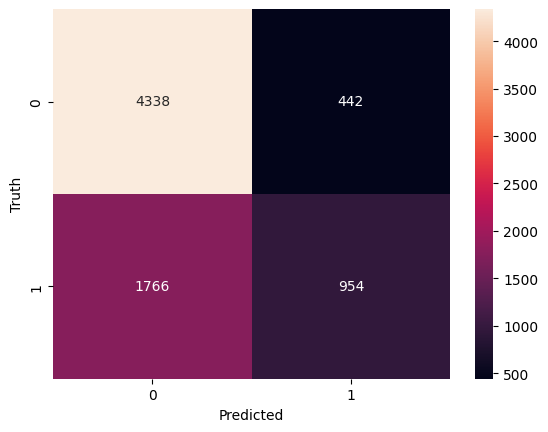

In [67]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [68]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.71      0.91      0.80      4780
           1       0.68      0.35      0.46      2720

    accuracy                           0.71      7500
   macro avg       0.70      0.63      0.63      7500
weighted avg       0.70      0.71      0.68      7500

